# Introduction

Takes exploratory data and fits variations of the DDM.

DDM: average-signal

Details: Take every signal that the subject saw in a trial, and average their values. Feed that into a DDM as a time-invariant signal.

## Preamble

In [1]:
# Install (package verification, PyDDM, timer, parallelization)
#!pip3 install paranoid-scientist
#!pip3 install pyddm
#!pip3 install pytictoc  
#!pip3 install pathos  
#!pip3 install pandas
#!pip3 install numpy
#!pip3 install matplotlib

# Python 3.9.13

In [2]:
# Libraries
import os
from pytictoc import TicToc
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
import pyddm as ddm
from pyddm import Model, Sample, FitResult, Fittable, Fitted, ICPoint, set_N_cpus
from pyddm.models import NoiseConstant, BoundConstant, OverlayChain, OverlayNonDecision, OverlayUniformMixture, LossRobustBIC
from pyddm.functions import fit_adjust_model, display_model
import pyddm.plot

In [3]:
# Directories
datadir = "/Users/ella/Desktop/2023-ddm-sampling-weights/data/processed_data/exploratory.csv"
tempdir = "/Users/ella/Desktop/2023-ddm-sampling-weights/analysis/outputs/temp/"

In [4]:
# Parallel settings
ncpu = multiprocessing.cpu_count()-1 # always save one core
ncpu

5

In [5]:
# Do you want a disgusting amount of feedback from model fitting or nah?
verbose_fitting = False

## Import and Clean Raw Data

rawdata_in: odd trials used for in-sample data for model fitting.

rawdata_out: even trials used for out-sample data for model predictions.

In [6]:
# Import data
rawdata = pd.read_csv(datadir)
rawdata = rawdata.rename(columns={"subj":"subject", "rxn_time":"rt"})

# Turn choice into numeric (1=Y, 0=N)
mapping = {"YES":1, "NO":0}
rawdata = rawdata.replace({"choice":mapping})

# Drop no-response trials.
rawdata = rawdata[~np.isnan(rawdata['choice'])]

# Convert rt from ms to s
rawdata.rt = rawdata.rt/1000

# Odd trials -> in-sample. Even trials -> out-sample.
ind = rawdata.trial % 2 != 0
rawdata_in = pd.DataFrame(data=rawdata[ind])
rawdata_out = pd.DataFrame(data=rawdata[~ind])
print(rawdata_in[["subject","trial"]].head(1))
print(rawdata_in[["subject","trial"]].tail(1))
print(rawdata_out[["subject","trial"]].head(1))
print(rawdata_out[["subject","trial"]].tail(1))

   subject  trial
0        1      1
       subject  trial
60659       25    299
   subject  trial
3        1      2
       subject  trial
60669       25    300


---
# Time-Invariant DDM: evidence = avg stimulus value

## Transform data

Average stimulus is rounded to the tenth decimal. This introduces noise into the fitting process, but it significantly speeds up the fitting process. Fitting is parallelized by spliting the job up by different average stimulus values. Reducing the number of unique average stimulus values allows for more efficient parallelization.

I'm taking this shortcut here because I think this is a poor way to estimate the DDM anyways. Average stimulus should be correlated to the reaction time, since the average is calculated according to how many stimuli the subject saw, which depends on their reaction time.

Data
               subject  trial  choice      rt  machine  stim
subject trial                                               
1       1            1      1     1.0  0.9739        1   2.0
        3            1      3     0.0  1.3940       -2  -1.8
        5            1      5     0.0  4.0545       -1  -0.8
        7            1      7     0.0  1.2802        0   0.1
        9            1      9     1.0  5.8468        2   1.0
        11           1     11     0.0  2.3290       -1  -0.4
Unique Stimulus Values
[-2.2 -2.1 -2.  -1.9 -1.8 -1.7 -1.6 -1.5 -1.4 -1.3 -1.2 -1.1 -1.  -0.9
 -0.8 -0.7 -0.6 -0.5 -0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3  0.4  0.5
  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3  1.4  1.5  1.6  1.7  1.8  1.9
  2.   2.1  2.2  2.3  2.4  2.5  2.6  2.7  2.8  2.9]
How many unique values?
52


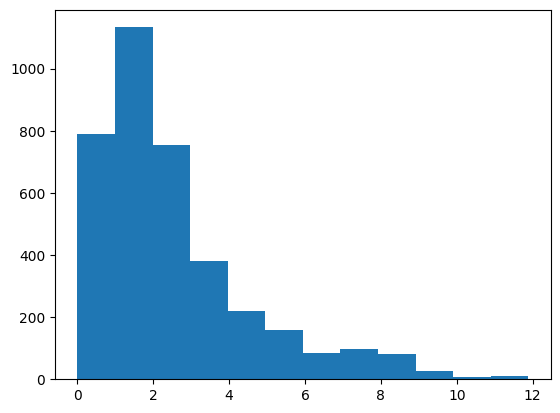

In [7]:
# Don't touch the raw data.
data = rawdata_in

# Get the first entry per subject-trial combo for most variables. Get the average stimulus variable.
data = data.groupby(["subject","trial"]).agg({"subject":'first', "trial":"first", "choice":"first", "rt":"first", "machine":"first", "stim":"mean"})

# Round average stimulus to tenth place.
data.stim = np.round(data.stim, 1)

# Display
plt.hist(data["rt"],bins=12)
print("Data")
print(data.head(6))
print("Unique Stimulus Values")
print(np.sort(data.stim.unique()))
print("How many unique values?")
print(len(data.stim.unique()))

## Fit the average stimulus DDM

In [8]:
# Create a drift subclass so drift can vary with stimulus.
class DriftStim(ddm.models.Drift):
  name = "Drift depends linearly on stimulus value"
  required_parameters = ["driftstim"] # Parameters we want to include in the model.
  required_conditions = ["stim"] # The column in your sample data that modulates the parameters above.
  def get_drift(self, conditions, **kwargs):
    return self.driftstim * conditions["stim"]

# Define the model.
model = Model(name="Time invariant drift modulated by average signal",
                 drift=DriftStim(driftstim=Fittable(minval=-1, maxval=4)),
                 noise=NoiseConstant(noise=Fittable(minval=.001, maxval=2)),
                 bound=BoundConstant(B=1),
                 IC=ICPoint(x0=Fittable(minval=-.99, maxval=.99)),
                 overlay=OverlayNonDecision(nondectime=Fittable(minval=0, maxval=.1)),
                 dx=.01, dt=.01, T_dur=12,  # dx: spatial grid for evidence space (-B to B, in dx bins), dt: time step in s. See Shin et al 2022 Fig 4 for why I set dx=dt.
                 choice_names=("Yes","No"))

In [9]:
# Only run this if specified at the start. Otherwise, just load pre-saved weights.
print("DDM: Time Invariant Drift")

# Iterate through subjects.
subnums = np.sort(data.subject.unique())
for subnum in subnums:

    # Progress tracker.
    print("============================================================================")
    print("Subject " + str(subnum))

    # Subset the data.
    subdata = data[data["subject"]==subnum]

    # Create a sample object from our data. Sample objects are the standard input for pyDDM fitting functions.
    ddm_data = Sample.from_pandas_dataframe(subdata, rt_column_name="rt", choice_column_name="choice", choice_names=("Yes","No"))

    # Fit the model and show it off. Keep track of how long it took to estimate the parameters.
    clock = TicToc() # Timer
    clock.tic()
    set_N_cpus(ncpu) # Parallelize
    fit_model = fit_adjust_model(sample=ddm_data, model=model,
                                    fitting_method="differential_evolution",
                                    lossfunction=LossRobustBIC,
                                    verbose=verbose_fitting)
    clock.toc("Fitting subject " + str(subnum) + " took")
    display_model(fit_model)

    # Save
    filename = tempdir + "fit_model_ti_" + str(subnum) + ".txt"
    with open(filename, "w") as f:
      f.write(repr(fit_model))

## Extract parameters and BIC for the model objects

In [10]:
# Placeholders
model_bic = []
model_drift = []
model_noise = []
model_bias = []
model_ndt = []

# Iterate through subjects.
subnums = np.sort(data.subject.unique())
for subnum in subnums:
    
    # Load
    filename = tempdir + "fit_model_ti_" + str(subnum) + ".txt"
    with open(filename, "r") as f:
        model_loaded = eval(f.read())

    # Negative Log Likelihood.
    model_bic.append(model_loaded.get_fit_result().value())
    
    # Fitted parameters.
    model_drift.append(model_loaded.parameters()['drift']['driftstim'])
    model_noise.append(model_loaded.parameters()['noise']['noise'])
    model_bias.append(model_loaded.parameters()['IC']['x0'])
    model_ndt.append(model_loaded.parameters()['overlay']['nondectime'])
    
d = {'bic':model_bic, "drift":model_drift, "noise":model_noise, "bias":model_bias, "ndt":model_ndt}
indiv_model = pd.DataFrame(data=d)
indiv_model

,bic,drift,noise,bias,ndt
0,443.576431,0.403546,0.368876,-0.278941,0.094668
1,875.981638,0.096721,0.194593,-0.066322,0.083425
2,550.617604,0.263634,0.274453,-0.224842,0.095580
3,698.004648,0.163944,0.192467,-0.096242,0.099018
4,780.101301,0.141472,0.239375,-0.083149,0.097455
5,506.062985,0.410498,0.876866,-0.269408,0.020913
6,1323.869324,0.094724,0.802427,0.435531,0.000836
7,477.307972,0.380505,0.686332,-0.126680,0.095847
8,527.372644,0.372288,0.563915,-0.045598,0.084873
9,283.728724,0.711251,0.882524,-0.224483,0.092215


## Means of BIC and Estimates

Confidence intervals assume normal distribution.

In [11]:
summstats_model = pd.DataFrame(data={"mean":indiv_model.mean(), 
                                        "se":indiv_model.sem(),
                                        "ci_lower":indiv_model.mean()-1.96*indiv_model.sem(),
                                        "ci_upper":indiv_model.mean()+1.96*indiv_model.sem()}).T
summstats_model

,bic,drift,noise,bias,ndt
mean,537.868875,0.363206,0.495371,-0.136397,0.086764
se,45.113070,0.033230,0.046792,0.033858,0.004735
ci_lower,449.447258,0.298075,0.403658,-0.202760,0.077484
ci_upper,626.290492,0.428336,0.587084,-0.070035,0.096045


## Save

In [12]:
table_model = pd.concat([indiv_model, summstats_model])
filename = tempdir + "table_model_ti.txt"
with open(filename, "w") as f:
  f.write(repr(table_model))